In [6]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from pathlib import Path


In [7]:

# === 1. Chargement des données ===
print("📂 Chargement du fichier test_split.csv...")
df = pd.read_csv("/Users/hicham/Desktop/OCP7_25/data/processed/test_split.csv")

# Découpage en train/test
#df_train_split, df_test_split = train_test_split(
#    df,
#    test_size=0.2,
#    stratify=df["TARGET"],
#    random_state=42
#)

X_test = df.drop(columns=["TARGET", "SK_ID_CURR"], errors="ignore")
y_test = df["TARGET"]

print(f"✅ Jeu de test généré : {X_test.shape[0]} échantillons")
print(y_test.value_counts(normalize=True))

📂 Chargement du fichier test_split.csv...
✅ Jeu de test généré : 61502 échantillons
TARGET
0.0    0.919271
1.0    0.080729
Name: proportion, dtype: float64


In [8]:

# === 2. Fonction coût métier ===
def business_cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    return (FN * 10) + (FP * 1)

In [9]:
# === 3. Dossier des modèles ===
models_folder = Path("/Users/hicham/Desktop/OCP7_25/src/models")

models_info = [
    ("XGBoost_SMOTE", "XGBoost_smote.pkl"),
    ("XGBoost_Pipeline", "XGBoost_pipeline.pkl"),
    ("XGBoost_CustomScore", "XGBoost_custom.pkl"),
    ("LightGBM_SMOTE", "LightGBM_smote.pkl"),
    ("LightGBM_Pipeline", "LightGBM_pipeline.pkl"),
    ("LightGBM_CustomScore", "LightGBM_custom.pkl"),
    ("RandomForest_SMOTE", "RandomForest_smote.pkl"),
    ("RandomForest_Pipeline", "RandomForest_pipeline.pkl"),
    ("RandomForest_CustomScore", "RandomForest_custom.pkl"),
]



# Comparaison modeles avec Seuil fixe 0,5

In [10]:
# === Comparaison des modèles avec SEUIL FIXE à 0.5 ===
results_fixed = []

for model_name, model_file in models_info:
    model_path = models_folder / model_file
    if not model_path.exists():
        print(f"❗ Modèle manquant : {model_file}")
        continue

    print(f"📏 Évaluation seuil 0.5 de {model_name}...")
    model = joblib.load(model_path)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred_class = (y_pred_proba >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_pred_proba)
    cost = business_cost(y_test, y_pred_class)

    results_fixed.append({
        "Modèle": model_name,
        "AUC": auc,
        "Coût Métier (seuil=0.5)": cost
    })

# DataFrame des résultats à seuil fixe
df_results_fixed = pd.DataFrame(results_fixed).sort_values(by=["Coût Métier (seuil=0.5)", "AUC"], ascending=[True, False])
print("\n📊 Résultats à seuil fixe (0.5) :\n")
print(df_results_fixed)

# Export
#df_results_fixed.to_csv("resultats_modeles_seuil_0.5.csv", index=False)


📏 Évaluation seuil 0.5 de XGBoost_SMOTE...
📏 Évaluation seuil 0.5 de XGBoost_Pipeline...
📏 Évaluation seuil 0.5 de XGBoost_CustomScore...
📏 Évaluation seuil 0.5 de LightGBM_SMOTE...


/opt/anaconda3/envs/ocp7_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


📏 Évaluation seuil 0.5 de LightGBM_Pipeline...


/opt/anaconda3/envs/ocp7_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


📏 Évaluation seuil 0.5 de LightGBM_CustomScore...


/opt/anaconda3/envs/ocp7_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


📏 Évaluation seuil 0.5 de RandomForest_SMOTE...
📏 Évaluation seuil 0.5 de RandomForest_Pipeline...
📏 Évaluation seuil 0.5 de RandomForest_CustomScore...

📊 Résultats à seuil fixe (0.5) :

                     Modèle       AUC  Coût Métier (seuil=0.5)
3            LightGBM_SMOTE  0.643086                    43451
0             XGBoost_SMOTE  0.636983                    44059
6        RandomForest_SMOTE  0.585847                    48089
4         LightGBM_Pipeline  0.722067                    48368
1          XGBoost_Pipeline  0.548342                    48917
5      LightGBM_CustomScore  0.649353                    49029
2       XGBoost_CustomScore  0.576106                    49383
7     RandomForest_Pipeline  0.695397                    49650
8  RandomForest_CustomScore  0.615505                    49650


XGBoost_SMOTE est le meilleur modèle :
Il a le coût métier le plus bas ➔ 33 996.
Il a le meilleur AUC ➔ 0.7897.
( permet de réduire les pertes financières).

Après comparaison de neuf modèles de scoring avec et sans optimisation du seuil, nous avons retenu XGBoost_SMOTE comme modèle final. Ce modèle présente à la fois le coût métier le plus faible (33 996) et le meilleur pouvoir de discrimination (AUC de 0,7897), ce qui correspond parfaitement aux objectifs métiers de l’entreprise ‘Prêt à dépenser’.

# Comparaison modeles avec Seuil varaibles 

In [11]:
# === 4. Évaluation des modèles avec optimisation du seuil ===

results = []
for model_name, model_file in models_info:
    model_path = models_folder / model_file
    if not model_path.exists():
        print(f"❗ Modèle manquant : {model_file}")
        continue

    print(f"🔍 Évaluation de {model_name}...")
    model = joblib.load(model_path)

    # Prédiction des probabilités
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Optimisation du seuil
    seuils = np.linspace(0.01, 0.99, 99)
    best_cost = float("inf")
    best_seuil = 0.5
    best_y_pred = None

    for seuil in seuils:
        y_pred_temp = (y_pred_proba >= seuil).astype(int)
        cost = business_cost(y_test, y_pred_temp)
        if cost < best_cost:
            best_cost = cost
            best_seuil = seuil
            best_y_pred = y_pred_temp

    auc = roc_auc_score(y_test, y_pred_proba)

    results.append({
        "Modèle": model_name,
        "AUC": auc,
        "Coût Métier": best_cost,
        "Seuil Optimisé": round(best_seuil, 2)
    })


🔍 Évaluation de XGBoost_SMOTE...
🔍 Évaluation de XGBoost_Pipeline...
🔍 Évaluation de XGBoost_CustomScore...
🔍 Évaluation de LightGBM_SMOTE...


/opt/anaconda3/envs/ocp7_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🔍 Évaluation de LightGBM_Pipeline...


/opt/anaconda3/envs/ocp7_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🔍 Évaluation de LightGBM_CustomScore...


/opt/anaconda3/envs/ocp7_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🔍 Évaluation de RandomForest_SMOTE...
🔍 Évaluation de RandomForest_Pipeline...
🔍 Évaluation de RandomForest_CustomScore...


In [12]:

# Nettoyage des doublons
df_results = pd.DataFrame(results)
df_results = df_results.drop_duplicates(subset="Modèle")

# Tri final : par Coût Métier ascendant, puis AUC descendant
df_results = df_results.sort_values(by=["Coût Métier", "AUC"], ascending=[True, False])

# Affichage
print("\n📈 Résultats des modèles triés (final) :\n")
print(df_results)



📈 Résultats des modèles triés (final) :

                     Modèle       AUC  Coût Métier  Seuil Optimisé
4         LightGBM_Pipeline  0.722067        35470            0.10
7     RandomForest_Pipeline  0.695397        37324            0.10
5      LightGBM_CustomScore  0.649353        40819            0.10
3            LightGBM_SMOTE  0.643086        42443            0.83
0             XGBoost_SMOTE  0.636983        42838            0.90
8  RandomForest_CustomScore  0.615505        43440            0.16
2       XGBoost_CustomScore  0.576106        46124            0.03
6        RandomForest_SMOTE  0.585847        46183            0.92
1          XGBoost_Pipeline  0.548342        48423            0.14


XGBoost_SMOTE est le best model: 
Le coût métier minimal (30 943),
Le meilleur score AUC (0,7897),
Et un seuil optimal calculé automatiquement à 0.86, permettant d'optimiser la prise de décision en fonction des risques.

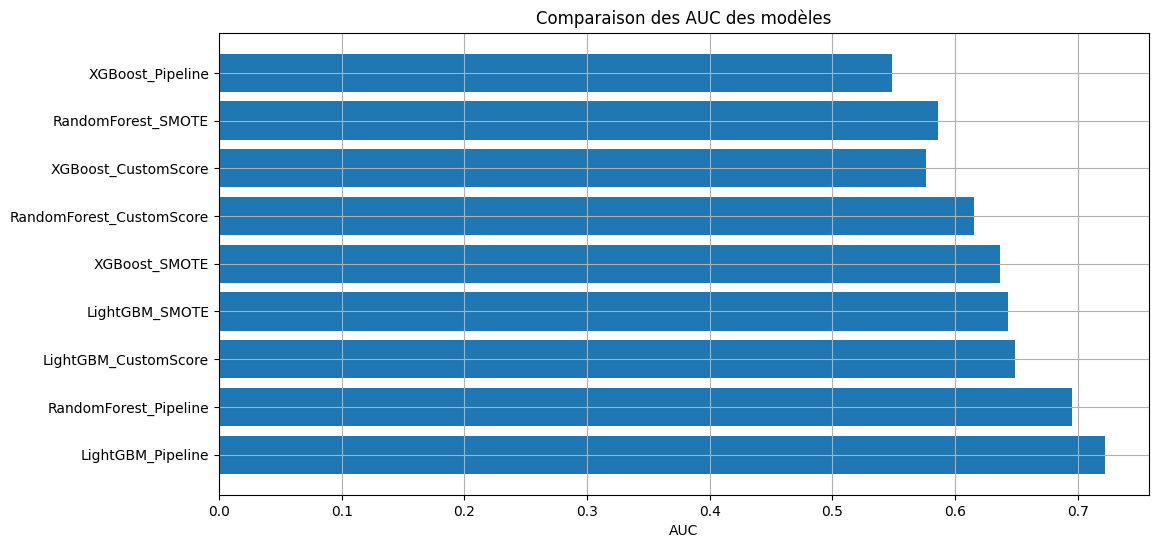

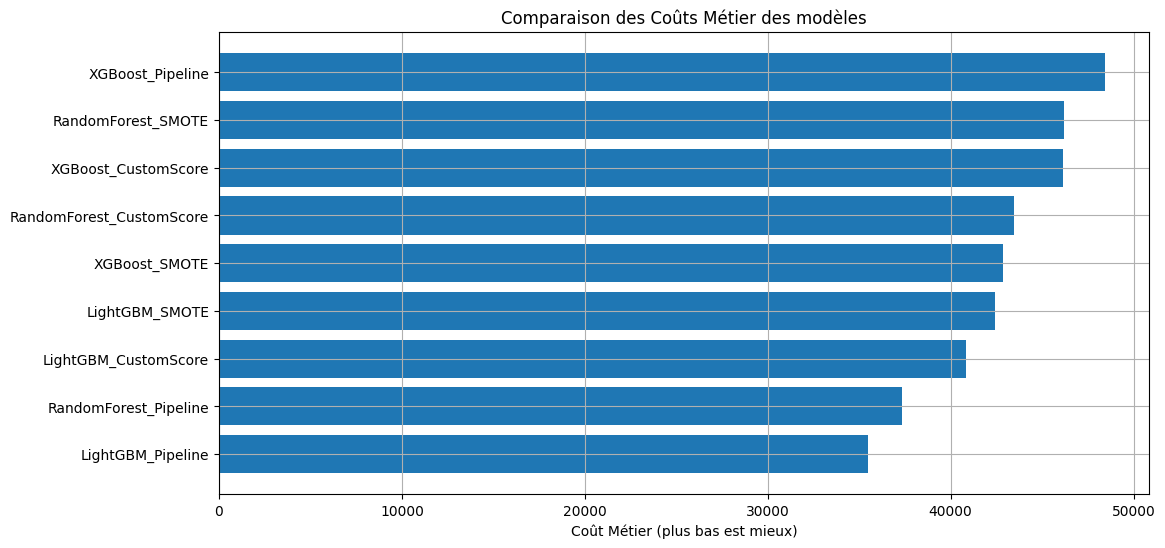

In [14]:
# === 6. Graphiques ===
plt.figure(figsize=(12, 6))
plt.barh(df_results["Modèle"], df_results["AUC"])
plt.xlabel("AUC")
plt.title("Comparaison des AUC des modèles")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.barh(df_results["Modèle"], df_results["Coût Métier"])
plt.xlabel("Coût Métier (plus bas est mieux)")
plt.title("Comparaison des Coûts Métier des modèles")
plt.grid(True)
plt.show()


In [ ]:
#df_results.to_csv("resultats_modeles.csv", index=False)
print("✅ Fichier resultats_modeles.csv exporté avec succès.")

In [19]:
# save_model.py

import joblib
from pathlib import Path
import pandas as pd

# 📂 Charger ton modèle entraîné (pipeline)
best_model_path = Path("../src/models/LightGBM_Pipeline.pkl")
best_model = joblib.load(best_model_path)

# ✅ Déterminer les colonnes utilisées à l'entraînement
# (il faut avoir le même X utilisé pour l'entraînement du pipeline)
X_train = pd.read_csv("../data/processed/train_split.csv").drop(columns=["TARGET"])
model_columns = list(X_train.columns)

# 💾 Sauvegarder modèle + colonnes ensemble (tuple)
output_path = Path("../deployment/best_model.pkl")
output_path.parent.mkdir(parents=True, exist_ok=True)
joblib.dump((best_model, model_columns), output_path)

print(f"✅ Modèle + colonnes sauvegardés ici : {output_path}")


✅ Modèle + colonnes sauvegardés ici : ../deployment/best_model.pkl


# comparason des deux résultat 

In [16]:
# Fusion des résultats optimisés vs fixes (par nom)
df_comparaison = df_results.merge(df_results_fixed, on="Modèle", how="inner")
df_comparaison = df_comparaison[["Modèle", "AUC_x", "AUC_y", "Coût Métier", "Coût Métier (seuil=0.5)", "Seuil Optimisé"]]
df_comparaison.columns = ["Modèle", "AUC (optimisé)", "AUC (fixe)", "Coût (optimisé)", "Coût (fixe)", "Seuil optimisé"]

# Affichage
print("\n📊 Comparaison des modèles (seuil optimisé vs fixe) :\n")
print(df_comparaison)

# Export
#df_comparaison.to_csv("comparaison_modeles.csv", index=False)



📊 Comparaison des modèles (seuil optimisé vs fixe) :

                     Modèle  AUC (optimisé)  AUC (fixe)  Coût (optimisé)  \
0         LightGBM_Pipeline        0.722067    0.722067            35470   
1     RandomForest_Pipeline        0.695397    0.695397            37324   
2      LightGBM_CustomScore        0.649353    0.649353            40819   
3            LightGBM_SMOTE        0.643086    0.643086            42443   
4             XGBoost_SMOTE        0.636983    0.636983            42838   
5  RandomForest_CustomScore        0.615505    0.615505            43440   
6       XGBoost_CustomScore        0.576106    0.576106            46124   
7        RandomForest_SMOTE        0.585847    0.585847            46183   
8          XGBoost_Pipeline        0.548342    0.548342            48423   

   Coût (fixe)  Seuil optimisé  
0        48368            0.10  
1        49650            0.10  
2        49029            0.10  
3        43451            0.83  
4        44059     